<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/dev/example%20LLM%20GNN%20fact%20checking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BioMedAI Fact Checking with RoBERTa + PubMed + Graph Neural Networks
======================================================================

This script demonstrates a comprehensive medical fact-checking system using:
1. RoBERTa transformer models for claim-evidence analysis
2. PubMed literature search for scientific evidence
3. Graph Neural Networks for knowledge graph reasoning

The system evaluates medical claims by analyzing evidence, searching relevant literature,
constructing knowledge graphs, and providing structured verdicts through advanced ML.

Fact Checking Process:
1. Data Preparation: Medical claims with evidence pairs
2. PubMed Literature Search: Scientific paper retrieval
3. Knowledge Graph Construction: Claims, evidence, and papers as nodes
4. Graph Neural Network Reasoning: Multi-hop reasoning over relationships
5. Model Training: Combined RoBERTa + GNN approach
6. Verdict Generation: Enhanced classification with confidence scores


In [1]:
!pip install torch_geometric --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.1 MB/s eta 0:00:00


In [2]:
#import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import to_networkx
import networkx as nx
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import logging
#from collections import Counter, defaultdict
#import warnings
import requests
import time
from urllib.parse import quote_plus
import xml.etree.ElementTree as ET
from torch.optim import AdamW

In [3]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Suppress warnings
#warnings.filterwarnings('ignore')


from google.colab import userdata

# Get Hugging Face and PubMed token from environment
HF_TOKEN = userdata.get("HF_token_example")
PUBMED_TOKEN = userdata.get("PubMed_token")

In [4]:
if PUBMED_TOKEN:
  print(f"✅ PubMed API token detected")
else:
  print("⚠️  No PubMed API token found. Set PUBMED_TOKEN environment variable to avoid rate limits.")

if HF_TOKEN:
  print("✅ Hugging Face token detected")
else:
  print("⚠️  No Hugging Face")

✅ PubMed API token detected
✅ Hugging Face token detected


In [5]:
class MedicalFactCheckingDataset(Dataset):
    """Dataset class for medical fact-checking data"""

    def __init__(self, claims, evidences, labels, tokenizer, max_length=512):
        self.claims = claims
        self.evidences = evidences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.claims)

    def __getitem__(self, idx):
        claim = str(self.claims[idx])
        evidence = str(self.evidences[idx])
        label = self.labels[idx]

        # Combine claim and evidence as input
        text = f"Claim: {claim} Evidence: {evidence}"

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

class MedicalKnowledgeGraph:
    """
    Knowledge Graph for Medical Fact Checking
    """

    def __init__(self):
        self.nodes = []
        self.edges = []
        self.node_features = []
        self.node_types = []
        self.node_id_map = {}
        self.node_labels = {}  # For visualization
        self.node_metadata = {}  # Store detailed metadata for each node

    def add_claim_node(self, claim_text, claim_id):
        """Add a claim node to the graph"""
        node_id = len(self.nodes)
        node_name = f"claim_{claim_id}"
        self.nodes.append(node_name)
        self.node_types.append('claim')
        # Handle None case
        claim_text = claim_text if claim_text else "Unknown Claim"
        self.node_labels[node_name] = claim_text[:50] + "..." if len(claim_text) > 50 else claim_text
        self.node_metadata[node_name] = {
            'full_text': claim_text,
            'type': 'claim',
            'id': claim_id
        }
        # Simple feature: text embedding placeholder
        self.node_features.append(self._text_to_features(claim_text))
        self.node_id_map[node_name] = node_id
        return node_id

    def add_evidence_node(self, evidence_text, evidence_id):
        """Add an evidence node to the graph"""
        node_id = len(self.nodes)
        node_name = f"evidence_{evidence_id}"
        self.nodes.append(node_name)
        self.node_types.append('evidence')
        # Handle None case
        evidence_text = evidence_text if evidence_text else "Unknown Evidence"
        self.node_labels[node_name] = evidence_text[:50] + "..." if len(evidence_text) > 50 else evidence_text
        self.node_metadata[node_name] = {
            'full_text': evidence_text,
            'type': 'evidence',
            'id': evidence_id
        }
        self.node_features.append(self._text_to_features(evidence_text))
        self.node_id_map[node_name] = node_id
        return node_id

    def add_paper_node(self, paper_info, paper_id):
        """Add a paper node to the graph"""
        node_id = len(self.nodes)
        node_name = f"paper_{paper_id}"
        self.nodes.append(node_name)
        self.node_types.append('paper')
        # Handle None case for title
        title = paper_info.get('title', 'Unknown Paper') if paper_info else 'Unknown Paper'
        title = title if title else 'Unknown Paper'
        self.node_labels[node_name] = title[:50] + "..." if len(title) > 50 else title
        self.node_metadata[node_name] = {
            'title': title,
            'authors': paper_info.get('authors', []) if paper_info else [],
            'journal': paper_info.get('journal', '') if paper_info else '',
            'year': paper_info.get('year', '') if paper_info else '',
            'pmid': paper_info.get('pmid', '') if paper_info else '',
            'type': 'paper',
            'id': paper_id,
            'relevance_score': paper_info.get('relevance_score', 0.5) if paper_info else 0.5
        }
        # Feature based on paper metadata
        features = self._paper_to_features(paper_info)
        self.node_features.append(features)
        self.node_id_map[node_name] = node_id
        return node_id

    def add_entity_node(self, entity_name, entity_type):
        """Add a medical entity node to the graph"""
        node_key = f"entity_{entity_name}_{entity_type}"
        if node_key in self.node_id_map:
            return self.node_id_map[node_key]

        node_id = len(self.nodes)
        self.nodes.append(node_key)
        self.node_types.append('entity')
        entity_display = f"{entity_name} ({entity_type})" if entity_name and entity_type else "Unknown Entity"
        self.node_labels[node_key] = entity_display[:50] + "..." if len(entity_display) > 50 else entity_display
        self.node_metadata[node_key] = {
            'name': entity_name if entity_name else "Unknown",
            'entity_type': entity_type if entity_type else "Unknown",
            'type': 'entity'
        }
        self.node_features.append(self._entity_to_features(entity_name, entity_type))
        self.node_id_map[node_key] = node_id
        return node_id

    def add_edge(self, source_node_id, target_node_id, relation_type, weight=1.0):
        """Add an edge between nodes"""
        self.edges.append((source_node_id, target_node_id, relation_type, weight))

    def _text_to_features(self, text):
        """Convert text to feature vector (simplified)"""
        if not text:
            return [0, 0, 0]
        words = str(text).lower().split()
        return [len(words), len(set(words)), sum(len(w) for w in words)/len(words) if words else 0]

    def _paper_to_features(self, paper_info):
        """Convert paper info to feature vector"""
        if not paper_info:
            return [0, 0, 0]
        return [1, paper_info.get('relevance_score', 0.5), len(paper_info.get('authors', []))]

    def _entity_to_features(self, entity_name, entity_type):
        """Convert entity to feature vector"""
        if not entity_name or not entity_type:
            return [0, 0, 0]
        type_map = {'disease': 1, 'drug': 2, 'symptom': 3, 'treatment': 4, 'cancer': 5, 'sugar': 6, 'sweetener': 7}
        return [type_map.get(entity_type, 0), len(entity_name), 1]

    def build_torch_geometric_data(self):
        """Convert to PyTorch Geometric format"""
        # Node features
        x = torch.tensor(self.node_features, dtype=torch.float)

        # Edge indices and attributes
        edge_index = []
        edge_attr = []

        for source, target, relation, weight in self.edges:
            edge_index.append([source, target])
            # Encode relation type
            relation_map = {'supports': 1, 'refutes': 2, 'cites': 3, 'mentions': 4, 'related': 5}
            edge_attr.append([relation_map.get(relation, 0), weight])

        if edge_index:
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)
            edge_attr = torch.empty((0, 2), dtype=torch.float)

        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

    def visualize_graph(self, claim_id=None, max_nodes=100, save_path=None, show_all=False):
        """
        Visualize the knowledge graph with enhanced styling and filtering options.
        """

        # Create NetworkX graph from edges
        G = nx.DiGraph()

        # Add all nodes with attributes
        node_colors = []
        node_sizes = []
        node_shapes = []
        node_color_map = {
            'claim': '#FF6B6B',      # Red for claims
            'evidence': '#4ECDC4',   # Teal for evidence
            'paper': '#45B7D1',      # Blue for papers
            'entity': '#96CEB4'      # Green for entities
        }

        node_shape_map = {
            'claim': 'o',      # Circle
            'evidence': 's',   # Square
            'paper': 'd',      # Diamond
            'entity': '^'      # Triangle
        }

        # Add all nodes to graph (or filter if claim_id is specified)
        if show_all or claim_id is None:
            # Show all nodes
            nodes_to_show = range(len(self.nodes))
        else:
            # Filter nodes if claim_id is specified
            claim_node_name = f"claim_{claim_id}"
            if claim_node_name in self.node_id_map:
                claim_node_id = self.node_id_map[claim_node_name]
                # Get connected nodes
                connected_nodes = {claim_node_id}
                for source, target, _, _ in self.edges:
                    if source == claim_node_id or target == claim_node_id:
                        connected_nodes.add(source)
                        connected_nodes.add(target)

                # Limit to max_nodes for visualization clarity
                nodes_to_show = list(connected_nodes)[:max_nodes]
            else:
                nodes_to_show = list(range(min(len(self.nodes), max_nodes)))

        # Add filtered nodes to graph
        for node_id in nodes_to_show:
            if node_id < len(self.nodes):
                node_name = self.nodes[node_id]
                node_type = self.node_types[node_id]
                G.add_node(node_name,
                          type=node_type,
                          label=self.node_labels.get(node_name, node_name),
                          metadata=self.node_metadata.get(node_name, {}))
                node_colors.append(node_color_map.get(node_type, '#CCCCCC'))
                node_sizes.append(300 if node_type == 'claim' else 150)
                node_shapes.append(node_shape_map.get(node_type, 'o'))

        # Add all edges between nodes in the graph
        edge_colors = []
        edge_styles = []
        edge_widths = []
        edge_labels = []
        edge_style_map = {
            'supports': 'solid',
            'refutes': 'dashed',
            'cites': 'dotted',
            'mentions': 'dashdot',
            'related': 'solid'
        }
        edge_color_map = {
            'supports': '#2E8B57',   # Green
            'refutes': '#DC143C',    # Crimson
            'cites': '#4169E1',      # Royal Blue
            'mentions': '#FF8C00',   # Dark Orange
            'related': '#808080'     # Gray
        }

        for source, target, relation, weight in self.edges:
            if source in nodes_to_show and target in nodes_to_show:
                G.add_edge(self.nodes[source], self.nodes[target],
                          relation=relation, weight=weight)
                edge_colors.append(edge_color_map.get(relation, '#000000'))
                edge_styles.append(edge_style_map.get(relation, 'solid'))
                edge_widths.append(max(0.5, weight * 2))  # Scale width by weight
                edge_labels.append(relation[:10])  # Short label for edges

        # Create visualization
        plt.figure(figsize=(20, 15))

        # Use spring layout with adjustments for better visualization
        pos = nx.spring_layout(G, k=3, iterations=50, seed=42)

        # Draw nodes by type (to get different shapes)
        for shape in set(node_shapes):
            nodes_of_shape = [n for n, ns in zip(G.nodes(), node_shapes)
                             if ns == shape and n in G.nodes()]
            if nodes_of_shape:
                nx.draw_networkx_nodes(G, pos,
                                     nodelist=nodes_of_shape,
                                     node_color=[node_colors[i] for i, ns in enumerate(node_shapes) if ns == shape and self.nodes[i] in G.nodes()],
                                     node_size=[node_sizes[i] for i, ns in enumerate(node_shapes) if ns == shape and self.nodes[i] in G.nodes()],
                                     node_shape=shape,
                                     alpha=0.8)

        # Draw edges
        nx.draw_networkx_edges(G, pos,
                              edge_color=edge_colors,
                              style=edge_styles,
                              width=edge_widths,
                              alpha=0.6,
                              arrows=True,
                              arrowsize=15)

        # Draw labels with better positioning
        labels = nx.get_node_attributes(G, 'label')
        nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight='bold')

        # Create legend
        legend_elements = []
        for node_type, color in node_color_map.items():
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                            markerfacecolor=color, markersize=10,
                                            label=f'{node_type.capitalize()}'))

        for relation, color in edge_color_map.items():
            legend_elements.append(plt.Line2D([0], [0], color=color, linestyle=edge_style_map.get(relation, 'solid'),
                                            linewidth=2, label=f'{relation.capitalize()}'))

        plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

        plt.title('Medical Knowledge Graph Visualization', fontsize=16, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()

        # Save or show
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Graph visualization saved to {save_path}")
        else:
            plt.show()

        # Print graph statistics
        print(f"\n📊 Graph Statistics:")
        print(f"  Nodes: {G.number_of_nodes()}")
        print(f"  Edges: {G.number_of_edges()}")
        node_types = nx.get_node_attributes(G, 'type')
        if node_types:
            print(f"  Node Types: {dict(Counter(node_types.values()))}")
        edge_relations = nx.get_edge_attributes(G, 'relation')
        if edge_relations:
            print(f"  Relationship Types: {dict(Counter(edge_relations.values()))}")

        return G

class GNNFactChecker(nn.Module):
    """
    Graph Neural Network for Medical Fact Checking
    """

    def __init__(self, num_node_features, hidden_dim=64, num_classes=2):
        super(GNNFactChecker, self).__init__()

        # GCN layers for local neighborhood aggregation
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)

        # GAT layer for attention-based reasoning
        self.gat1 = GATConv(hidden_dim, hidden_dim, heads=4, dropout=0.1)
        self.gat2 = GATConv(hidden_dim * 4, hidden_dim, heads=1, dropout=0.1)

        # Classification layers
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # GCN layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # GAT layers
        x = self.gat1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.gat2(x, edge_index)

        # Global pooling (mean pooling)
        graph_embedding = torch.mean(x, dim=0, keepdim=True)

        # Classification
        output = self.classifier(graph_embedding)

        return output.squeeze(0)

class HybridFactChecker(nn.Module):
    """
    Hybrid Fact Checker combining RoBERTa and GNN
    """

    def __init__(self, roberta_model, gnn_model, hidden_dim=64):
        super(HybridFactChecker, self).__init__()
        self.roberta = roberta_model
        self.gnn = gnn_model

        # Fusion layer
        self.fusion = nn.Linear(hidden_dim + 768, hidden_dim)  # 768 = RoBERTa hidden size
        self.classifier = nn.Linear(hidden_dim, 2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask, graph_data):
        # RoBERTa encoding
        roberta_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        roberta_embedding = roberta_outputs.last_hidden_state[:, 0, :]  # CLS token

        # GNN encoding
        gnn_output = self.gnn(graph_data).unsqueeze(0)

        # Fusion
        combined = torch.cat([roberta_embedding, gnn_output], dim=1)
        fused = F.relu(self.fusion(combined))
        fused = self.dropout(fused)

        # Final classification
        logits = self.classifier(fused)

        return logits

def parse_pubmed_xml(xml_content):
    """
    Parse PubMed XML content to extract paper information and citations.
    """
    try:
        if not xml_content:
            return []
        root = ET.fromstring(xml_content)
        papers = []

        for article in root.findall('.//PubmedArticle'):
            # Extract PMID
            pmid_elem = article.find('.//PMID')
            pmid = pmid_elem.text if pmid_elem is not None and pmid_elem.text else 'Unknown'

            # Extract title
            title_elem = article.find('.//ArticleTitle')
            title = title_elem.text if title_elem is not None and title_elem.text else 'Unknown Title'

            # Extract authors
            authors = []
            for author in article.findall('.//Author'):
                lastname_elem = author.find('LastName')
                firstname_elem = author.find('ForeName')
                if lastname_elem is not None and firstname_elem is not None and lastname_elem.text and firstname_elem.text:
                    authors.append(f"{firstname_elem.text} {lastname_elem.text}")

            # Extract journal
            journal_elem = article.find('.//Journal/Title')
            journal = journal_elem.text if journal_elem is not None and journal_elem.text else 'Unknown Journal'

            # Extract year
            year_elem = article.find('.//PubDate/Year')
            year = year_elem.text if year_elem is not None and year_elem.text else 'Unknown Year'

            papers.append({
                'pmid': pmid,
                'title': title,
                'authors': authors,
                'journal': journal,
                'year': year
            })

        return papers
    except Exception as e:
        logger.warning(f"Failed to parse PubMed XML: {e}")
        return []

def search_pubmed(query, max_results=5, api_key=None):
    """
    Search PubMed for relevant medical literature with proper API key usage and rate limiting.
    """

    # Construct PubMed API URLs
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    fetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"

    # Prepare search parameters with API key
    params = {
        'db': 'pubmed',
        'term': query,
        'retmax': max_results,
        'retmode': 'json',
        'sort': 'relevance'
    }

    # Add API key if provided
    if api_key:
        params['api_key'] = api_key

    try:
        # Search for papers
        search_response = requests.get(base_url, params=params, timeout=10)
        search_response.raise_for_status()
        search_data = search_response.json()

        # Extract PMIDs
        pmids = search_data.get('esearchresult', {}).get('idlist', [])

        if not pmids:
            return {
                'papers': [],
                'abstracts': [],
                'total_papers': 0,
                'confidence_boost': 0,
                'literature_evidence': 'No relevant literature found'
            }

        # Fetch paper details with rate limiting
        fetch_params = {
            'db': 'pubmed',
            'id': ','.join(pmids),
            'retmode': 'xml',
            'rettype': 'abstract'
        }

        # Add API key to fetch request as well
        if api_key:
            fetch_params['api_key'] = api_key

        # Rate limiting - add delay to respect API limits
        time.sleep(0.2)  # 200ms delay between requests

        fetch_response = requests.get(fetch_url, params=fetch_params, timeout=10)
        fetch_response.raise_for_status()

        # Parse XML response
        papers = parse_pubmed_xml(fetch_response.text)

        # Add relevance scores and abstracts
        abstracts = []
        for i, paper in enumerate(papers):
            if 'relevance_score' not in paper:
                paper['relevance_score'] = max(0.7, 1.0 - i * 0.1)  # Decreasing relevance
            abstracts.append(f"Abstract of study examining {query}. Findings support current medical understanding.")

        # Calculate confidence boost based on literature quality
        confidence_boost = min(0.3, len(papers) * 0.1)  # Max 30% confidence boost

        literature_evidence = f"Found {len(papers)} relevant studies. "
        if len(papers) >= 2:
            literature_evidence += "Strong literature support."
        elif len(papers) == 1:
            literature_evidence += "Moderate literature support."
        else:
            literature_evidence += "Limited literature support."

        return {
            'papers': papers,
            'abstracts': abstracts,
            'total_papers': len(papers),
            'confidence_boost': confidence_boost,
            'literature_evidence': literature_evidence
        }

    except requests.exceptions.HTTPError as e:
        if e.response.status_code == 429:
            logger.warning(f"PubMed API rate limit exceeded for query '{query}'. Consider using an API key.")
            # Return empty results instead of failing
            return {
                'papers': [],
                'abstracts': [],
                'total_papers': 0,
                'confidence_boost': 0,
                'literature_evidence': 'API rate limit exceeded. Try again later.'
            }
        else:
            logger.warning(f"PubMed search failed for query '{query}': {e}")
            return {
                'papers': [],
                'abstracts': [],
                'total_papers': 0,
                'confidence_boost': 0,
                'literature_evidence': f'Literature search error: {str(e)}'
            }
    except Exception as e:
        logger.warning(f"PubMed search failed for query '{query}': {e}")
        return {
            'papers': [],
            'abstracts': [],
            'total_papers': 0,
            'confidence_boost': 0,
            'literature_evidence': f'Literature search error: {str(e)}'
        }

def enhance_claim_with_literature(claim, verdict):
    """
    Enhance claim evaluation with PubMed literature search.
    """

    # Construct search query based on claim and verdict
    if verdict == 'Supported by Evidence':
        # Look for supporting evidence
        search_query = f"{claim} AND (clinical trial OR meta-analysis OR systematic review)"
    else:
        # Look for contradicting evidence or studies showing no effect
        search_query = f"{claim} AND (no effect OR contradicts OR systematic review)"

    # Perform PubMed search
    pubmed_results = search_pubmed(search_query, max_results=5, api_key=PUBMED_TOKEN)

    # Generate enhanced evidence text
    if pubmed_results['total_papers'] > 0:
        literature_summary = f"PubMed literature review found {pubmed_results['total_papers']} relevant papers. "
        literature_summary += pubmed_results['literature_evidence']
        enhanced_evidence = f"{pubmed_results['literature_evidence']} {pubmed_results['abstracts'][0][:200]}..."
    else:
        literature_summary = "No relevant PubMed literature found for this claim."
        enhanced_evidence = f"No PubMed literature available. {pubmed_results['literature_evidence']}"

    return {
        'enhanced_evidence': enhanced_evidence,
        'literature_summary': literature_summary,
        'confidence_boost': pubmed_results['confidence_boost'],
        'papers_found': pubmed_results['total_papers'],
        'papers': pubmed_results['papers']
    }

def build_knowledge_graph_for_claim(claim, evidence, papers, claim_id):
    """
    Build knowledge graph for a single claim-evidence pair with paper citations.
    """

    kg = MedicalKnowledgeGraph()

    # Add nodes
    claim_node_id = kg.add_claim_node(claim, claim_id)
    evidence_node_id = kg.add_evidence_node(evidence, claim_id)

    # Add paper nodes
    paper_node_ids = []
    paper_metadata = {}
    for i, paper in enumerate(papers):
        paper_node_id = kg.add_paper_node(paper, f"{claim_id}_{i}")
        paper_node_ids.append(paper_node_id)
        paper_metadata[paper_node_id] = paper

    # Add entity nodes (simplified extraction)
    entities = extract_medical_entities(claim)
    entity_node_ids = []
    for entity, entity_type in entities:
        entity_node_id = kg.add_entity_node(entity, entity_type)
        entity_node_ids.append(entity_node_id)

    # Add edges
    # Claim-Evidence relationship
    kg.add_edge(claim_node_id, evidence_node_id, 'related', weight=1.0)
    kg.add_edge(evidence_node_id, claim_node_id, 'related', weight=1.0)

    # Evidence-Paper relationships
    for paper_node_id in paper_node_ids:
        kg.add_edge(evidence_node_id, paper_node_id, 'supports', weight=0.8)
        kg.add_edge(paper_node_id, evidence_node_id, 'related', weight=0.6)

    # Claim-Entity relationships
    for entity_node_id in entity_node_ids:
        kg.add_edge(claim_node_id, entity_node_id, 'mentions', weight=0.7)
        kg.add_edge(entity_node_id, claim_node_id, 'mentioned_in', weight=0.7)

    # Paper-Paper citations (simplified - in practice, extract from references)
    # For demonstration, create citation network based on relevance scores
    if len(paper_node_ids) > 1:
        # Sort papers by relevance score
        paper_scores = [(pid, paper_metadata[pid].get('relevance_score', 0.5)) for pid in paper_node_ids]
        paper_scores.sort(key=lambda x: x[1], reverse=True)

        # Create citation links from higher relevance to lower relevance papers
        for i in range(len(paper_scores) - 1):
            source_pid = paper_scores[i][0]
            target_pid = paper_scores[i + 1][0]
            citation_weight = 0.5 + (paper_scores[i][1] - paper_scores[i + 1][1]) * 2
            kg.add_edge(source_pid, target_pid, 'cites', weight=min(1.0, citation_weight))

    return kg

def extract_medical_entities(text):
    """
    Simple medical entity extraction (in practice, use medical NER models).
    Returns list of (entity, type) tuples.
    """
    if not text:
        return []
    # Simplified entity extraction
    entities = []

    # Disease keywords
    diseases = ['disease', 'disorder', 'syndrome', 'condition', 'infection', 'cancer', 'diabetes', 'hypertension', 'obesity']
    for disease in diseases:
        if disease in text.lower():
            entities.append((disease, 'disease'))

    # Treatment keywords
    treatments = ['treatment', 'therapy', 'medication', 'drug', 'vaccine', 'sweetener', 'sugar', 'additive']
    for treatment in treatments:
        if treatment in text.lower():
            entities.append((treatment, 'treatment'))

    # Symptom keywords
    symptoms = ['symptom', 'sign', 'effect', 'impact', 'risk', 'mortality', 'weight', 'cancer']
    for symptom in symptoms:
        if symptom in text.lower():
            entities.append((symptom, 'symptom'))

    return entities

def load_and_preprocess_medical_data(visualize=True, use_pubmed=True, use_gnn=True):
    """
    Load and preprocess sample medical fact-checking data with imbalanced distribution
    and optional PubMed literature + GNN integration.
    """
    logger.info("Loading and preprocessing medical data...")

    # Base medical claims - realistic examples
    base_claims_supported = [
        "Regular exercise reduces cardiovascular disease risk.",
        "Mediterranean diet promotes longevity.",
        "Chronic stress weakens immune function.",
        "Sleep deprivation impairs cognitive performance.",
        "Breastfeeding boosts infant immunity.",
        "Omega-3 fatty acids benefit heart health.",
        "High fiber diet reduces colon cancer risk.",
        "Sun exposure in moderation provides vitamin D benefits.",
        "Probiotics support digestive health.",
        "Mindfulness meditation reduces anxiety.",
        "Vaccination prevents infectious diseases.",
        "Hand washing prevents disease transmission.",
        "Adequate hydration supports kidney function.",
        "Strength training maintains muscle mass with aging.",
        "Fruits and vegetables provide essential antioxidants."
    ]

    base_claims_refuted = [
        "Vitamin C can cure the common cold.",
        "Antibiotics treat viral infections.",
        "Probiotics cure serious bacterial infections.",
        "Eating carrots significantly improves night vision.",
        "Vaccines cause autism.",
        "Drinking exactly 8 glasses of water daily is required.",
        "MSG causes headaches in everyone.",
        "Microwave cooking destroys all nutrients.",
        "Red wine consumption is always heart-healthy.",
        "Artificial sweeteners cause cancer.",
        "Detox diets are necessary for body cleansing.",
        "Protein intake damages healthy kidneys.",
        "Crash diets are effective for long-term weight loss.",
        "Supplements replace a balanced diet.",
        "All fats are bad for health.",
        "Organic food always prevents disease.",
        "Homeopathy cures serious illnesses.",
        "Essential oils cure chronic conditions.",
        "Fasting cleanses toxins from organs.",
        "Alkaline water prevents cancer."
    ]

    # Simulate a larger, imbalanced dataset (~90% Refuted)
    num_supported = 300  # Reduced for testing
    num_refuted = int(0.9 * (len(base_claims_supported) + len(base_claims_refuted)) * 2)

    supported_claims = np.random.choice(base_claims_supported, size=num_supported, replace=True).tolist()
    refuted_claims = np.random.choice(base_claims_refuted, size=num_refuted, replace=True).tolist()

    all_claims = supported_claims + refuted_claims
    all_verdicts = ['Supported by Evidence'] * len(supported_claims) + ['Refuted by Evidence'] * len(refuted_claims)

    combined = list(zip(all_claims, all_verdicts))
    np.random.shuffle(combined)
    claims_shuffled, verdicts_shuffled = zip(*combined)
    claims_shuffled, verdicts_shuffled = list(claims_shuffled), list(verdicts_shuffled)

    # Generate corresponding evidence texts with optional PubMed integration
    evidence_texts = []
    labels = []
    literature_info = []
    knowledge_graphs = []

    print("🔍 Integrating PubMed literature search and GNN knowledge graphs...")

    for i, (claim, verdict) in enumerate(zip(claims_shuffled, verdicts_shuffled)):
        if i % 5 == 0:  # Progress indicator
            print(f"  Processing claim {i+1}/{len(claims_shuffled)}: {claim[:50] if claim else 'Unknown Claim'}...")

        if verdict == 'Supported by Evidence':
            # Generate supporting evidence
            base_evidence = f"Clinical studies and meta-analyses consistently demonstrate that {claim.lower()[:-1] if claim else 'unknown claim'} is supported by robust scientific evidence."
            label = 1  # Supported
        else:
            # Generate refuting evidence
            base_evidence = f"Epidemiological research and systematic reviews show that {claim.lower()[:-1] if claim else 'unknown claim'} is contradicted by current medical understanding."
            label = 0  # Refuted

        # Integrate PubMed literature if enabled
        if use_pubmed:
            literature_results = enhance_claim_with_literature(claim, verdict)
            enhanced_evidence = f"{base_evidence} {literature_results['enhanced_evidence']}"
            literature_summary = literature_results['literature_summary']
            papers = literature_results['papers']
        else:
            enhanced_evidence = base_evidence
            literature_summary = "PubMed integration disabled"
            papers = []

        # Build knowledge graph if GNN is enabled
        if use_gnn:
            kg = build_knowledge_graph_for_claim(claim, enhanced_evidence, papers, i)
            knowledge_graphs.append(kg)
        else:
            # Create empty knowledge graph
            kg = MedicalKnowledgeGraph()
            knowledge_graphs.append(kg)

        evidence_texts.append(enhanced_evidence)
        labels.append(label)
        literature_info.append(literature_summary)

        # Rate limiting for PubMed API - only when actually making requests
        if use_pubmed and literature_results['papers_found'] > 0:
            time.sleep(0.1)  # Brief delay to respect API limits

    # Create DataFrame
    df = pd.DataFrame({
        'medical_claim': claims_shuffled,
        'evidence_text': evidence_texts,
        'label': labels,
        'verdict_text': verdicts_shuffled,
        'literature_info': literature_info
    })

    logger.info(f"Loaded {len(df)} medical claim-evidence pairs")
    logger.info(f"Class distribution - Supported: {sum(labels)}, Refuted: {len(labels) - sum(labels)}")

    return df, knowledge_graphs

def visualize_all_graphs(knowledge_graphs, save_path='complete_knowledge_graph.png'):
    """
    Visualize all knowledge graphs combined into one comprehensive graph.
    """

    print(f"\n🎨 Creating comprehensive visualization of all knowledge graphs...")

    # Create a unified graph combining all individual graphs
    unified_kg = MedicalKnowledgeGraph()
    node_mapping = {}  # Map old node IDs to new unified IDs
    paper_citations = []  # Store citation relationships

    # Process each knowledge graph
    for kg_idx, kg in enumerate(knowledge_graphs):
        # Add all nodes from this graph
        for i, (node_name, node_type) in enumerate(zip(kg.nodes, kg.node_types)):
            if node_name not in node_mapping:
                # Add node to unified graph
                metadata = kg.node_metadata.get(node_name, {})
                if node_type == 'claim':
                    unified_kg.add_claim_node(metadata.get('full_text', ''),
                                            metadata.get('id', kg_idx))
                elif node_type == 'evidence':
                    unified_kg.add_evidence_node(metadata.get('full_text', ''),
                                               metadata.get('id', kg_idx))
                elif node_type == 'paper':
                    unified_kg.add_paper_node(metadata,
                                            metadata.get('id', kg_idx))
                elif node_type == 'entity':
                    unified_kg.add_entity_node(metadata.get('name', ''),
                                             metadata.get('entity_type', ''))

                node_mapping[node_name] = len(unified_kg.nodes) - 1

        # Add all edges from this graph
        for source_id, target_id, relation, weight in kg.edges:
            source_name = kg.nodes[source_id]
            target_name = kg.nodes[target_id]

            if source_name in node_mapping and target_name in node_mapping:
                unified_kg.add_edge(node_mapping[source_name],
                                  node_mapping[target_name],
                                  relation, weight)

    # Visualize the unified graph
    try:
        print("  Creating comprehensive graph visualization...")
        graph_nx = unified_kg.visualize_graph(show_all=True, save_path=save_path)
        print(f"  ✅ Complete knowledge graph visualization saved to {save_path}")

        return unified_kg
    except Exception as e:
        print(f"  ❌ Failed to create comprehensive visualization: {e}")
        return None

def train_and_evaluate_medical_baseline(model_name='roberta-base', epochs=2, batch_size=4, learning_rate=2e-5, visualize=True, use_pubmed=True, use_gnn=True):
    """
    Main function to load medical data, prepare model, train, and evaluate the hybrid system,
    including visualizations of the process and results.
    """
    logger.info("Starting Hybrid Medical Fact Checking (RoBERTa + PubMed + GNN)...")

    # 1. Load and preprocess medical data
    df, knowledge_graphs = load_and_preprocess_medical_data(visualize=visualize, use_pubmed=use_pubmed, use_gnn=use_gnn)
    if df.empty:
        logger.error("No medical data available after preprocessing. Exiting.")
        return None, None, 0, "No data"

    # 2. Visualize all knowledge graphs combined
    if visualize and use_gnn and knowledge_graphs:
        unified_graph = visualize_all_graphs(knowledge_graphs, save_path='complete_knowledge_graph.png')

    # 3. Prepare data for training
    claims = df['medical_claim'].tolist()
    evidences = df['evidence_text'].tolist()
    labels = df['label'].tolist()

    train_claims, val_claims, train_evidences, val_evidences, train_labels, val_labels = train_test_split(
        claims, evidences, labels, test_size=0.2, random_state=42, stratify=labels
    )

    # Split knowledge graphs accordingly
    train_indices, val_indices = train_test_split(
        range(len(claims)), test_size=0.2, random_state=42, stratify=labels
    )
    train_knowledge_graphs = [knowledge_graphs[i] for i in train_indices] if knowledge_graphs else []
    val_knowledge_graphs = [knowledge_graphs[i] for i in val_indices] if knowledge_graphs else []

    # Convert knowledge graphs to PyTorch Geometric data
    train_graph_data = [kg.build_torch_geometric_data() for kg in train_knowledge_graphs] if train_knowledge_graphs else []
    val_graph_data = [kg.build_torch_geometric_data() for kg in val_knowledge_graphs] if val_knowledge_graphs else []

    if visualize:
        split_data = pd.DataFrame({
            'Split': ['Train'] * len(train_labels) + ['Validation'] * len(val_labels),
            'Label': train_labels + val_labels
        })
        label_names = {0: 'Refuted', 1: 'Supported'}
        split_data['Label_Name'] = split_data['Label'].map(label_names)

        plt.figure(figsize=(12, 5))
        ax1 = plt.subplot(1, 2, 1)
        split_counts = split_data['Split'].value_counts()
        sns.barplot(x=split_counts.index, y=split_counts.values, palette='Set2', ax=ax1)
        ax1.set_title('Data Split Sizes')
        ax1.set_ylabel('Number of Samples')

        ax2 = plt.subplot(1, 2, 2)
        crosstab_df = pd.crosstab(split_data['Split'], split_data['Label_Name'])
        crosstab_df.plot(kind='bar', ax=ax2, color=['salmon', 'skyblue'])
        ax2.set_title('Label Distribution in Splits')
        ax2.set_xlabel('Data Split')
        ax2.set_ylabel('Count')
        ax2.legend(title='Verdict')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
        logger.info("Displayed data split visualization.")

    # 4. Load tokenizer and RoBERTa model using HF_TOKEN
    logger.info(f"Loading tokenizer and model '{model_name}' from Hugging Face...")
    try:
        # Pass the token when loading from_pretrained
        tokenizer_kwargs = {"use_auth_token": HF_TOKEN} if HF_TOKEN else {}
        model_kwargs = {"use_auth_token": HF_TOKEN} if HF_TOKEN else {}

        tokenizer = RobertaTokenizer.from_pretrained(model_name, **tokenizer_kwargs)
        roberta_model = RobertaModel.from_pretrained(model_name, **model_kwargs)
        logger.info("Tokenizer and RoBERTa model loaded successfully.")
    except Exception as e:
        logger.error(f"Failed to load tokenizer or model '{model_name}': {e}")
        return None, None, 0, f"Load Error: {e}"

    # 5. Initialize GNN model
    if use_gnn:
        gnn_model = GNNFactChecker(num_node_features=3, hidden_dim=64, num_classes=2)
        hybrid_model = HybridFactChecker(roberta_model, gnn_model)
        logger.info("GNN and Hybrid model initialized successfully.")
    else:
        # Fallback to RoBERTa-only model
        hybrid_model = roberta_model
        logger.info("Using RoBERTa-only model (GNN disabled).")

    # 6. Create datasets and dataloaders
    train_dataset = MedicalFactCheckingDataset(train_claims, train_evidences, train_labels, tokenizer)
    val_dataset = MedicalFactCheckingDataset(val_claims, val_evidences, val_labels, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # 7. Setup training
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    hybrid_model.to(device)
    optimizer = AdamW(hybrid_model.parameters(), lr=learning_rate)

    # Store metrics for each epoch
    epoch_metrics = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }

    # 8. Training loop with epoch-by-epoch results
    logger.info("Starting training loop...")
    for epoch in range(epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"{'='*60}")

        # Training phase
        hybrid_model.train()
        total_train_loss = 0
        train_steps = 0

        for batch_idx, batch in enumerate(train_loader):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels_batch = batch['labels'].to(device)

            # Forward pass (simplified - in practice, handle graph data properly)
            if use_gnn:
                # This is a simplified approach - in practice, you'd batch graph data properly
                roberta_outputs = hybrid_model.roberta(input_ids=input_ids, attention_mask=attention_mask)
                outputs = roberta_outputs.last_hidden_state[:, 0, :]  # CLS token
                # Add simple classification head
                classifier = nn.Linear(outputs.size(-1), 2).to(device)
                outputs = classifier(outputs)
            else:
                # RoBERTa-only forward pass
                roberta_outputs = hybrid_model(input_ids=input_ids, attention_mask=attention_mask)
                outputs = roberta_outputs.last_hidden_state[:, 0, :]  # CLS token
                # Add simple classification head for RoBERTa-only
                classifier = nn.Linear(outputs.size(-1), 2).to(device)
                outputs = classifier(outputs)

            # Compute loss
            if len(outputs.shape) == 1:
                outputs = outputs.unsqueeze(0)
            loss = F.cross_entropy(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            train_steps += 1

            if batch_idx % 2 == 0:  # Print every 2 batches
                print(f"  Batch {batch_idx}: Train Loss = {loss.item():.4f}")

        avg_train_loss = total_train_loss / train_steps if train_steps > 0 else 0
        epoch_metrics['train_loss'].append(avg_train_loss)

        # Validation phase
        hybrid_model.eval()
        total_val_loss = 0
        val_predictions = []
        val_true_labels = []
        val_steps = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels_batch = batch['labels'].to(device)

                # Forward pass
                if use_gnn:
                    roberta_outputs = hybrid_model.roberta(input_ids=input_ids, attention_mask=attention_mask)
                    outputs = roberta_outputs.last_hidden_state[:, 0, :]
                    classifier = nn.Linear(outputs.size(-1), 2).to(device)
                    outputs = classifier(outputs)
                else:
                    roberta_outputs = hybrid_model(input_ids=input_ids, attention_mask=attention_mask)
                    outputs = roberta_outputs.last_hidden_state[:, 0, :]
                    classifier = nn.Linear(outputs.size(-1), 2).to(device)
                    outputs = classifier(outputs)

                if len(outputs.shape) == 1:
                    outputs = outputs.unsqueeze(0)

                loss = F.cross_entropy(outputs, labels_batch)
                logits = outputs

                total_val_loss += loss.item()
                val_steps += 1

                predictions = torch.argmax(logits, dim=-1)
                val_predictions.extend(predictions.cpu().numpy())
                val_true_labels.extend(labels_batch.cpu().numpy())

        avg_val_loss = total_val_loss / val_steps if val_steps > 0 else 0
        accuracy = accuracy_score(val_true_labels, val_predictions) if val_true_labels and val_predictions else 0
        if val_true_labels and val_predictions:
            precision, recall, f1, _ = precision_recall_fscore_support(val_true_labels, val_predictions, average='weighted')
        else:
            precision = recall = f1 = 0

        # Store metrics
        epoch_metrics['val_loss'].append(avg_val_loss)
        epoch_metrics['val_accuracy'].append(accuracy)
        epoch_metrics['val_precision'].append(precision)
        epoch_metrics['val_recall'].append(recall)
        epoch_metrics['val_f1'].append(f1)

        # Print epoch results
        print(f"\nEpoch {epoch + 1} Results:")
        print(f"  Average Train Loss: {avg_train_loss:.4f}")
        print(f"  Average Val Loss: {avg_val_loss:.4f}")
        print(f"  Validation Accuracy: {accuracy:.4f}")
        print(f"  Validation Precision: {precision:.4f}")
        print(f"  Validation Recall: {recall:.4f}")
        print(f"  Validation F1-Score: {f1:.4f}")

        # Confusion matrix for current epoch
        if val_true_labels and val_predictions:
            cm = confusion_matrix(val_true_labels, val_predictions)
            print(f"  Confusion Matrix: {cm.flatten()}")

    # 9. Final evaluation and visualization
    final_accuracy = epoch_metrics['val_accuracy'][-1] if epoch_metrics['val_accuracy'] else 0
    final_f1 = epoch_metrics['val_f1'][-1] if epoch_metrics['val_f1'] else 0

    print(f"\n{'='*60}")
    print("FINAL MODEL PERFORMANCE")
    print(f"{'='*60}")
    print(f"Final Accuracy: {final_accuracy:.4f}")
    print(f"Final F1-Score: {final_f1:.4f}")

    # Create comprehensive visualization dashboard
    if visualize:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Hybrid Medical Fact-Checking Training Dashboard', fontsize=16, fontweight='bold')

        # 1. Training and Validation Loss
        axes[0, 0].plot(range(1, len(epoch_metrics['train_loss']) + 1), epoch_metrics['train_loss'], 'b-', marker='o', label='Train Loss')
        axes[0, 0].plot(range(1, len(epoch_metrics['val_loss']) + 1), epoch_metrics['val_loss'], 'r-', marker='s', label='Val Loss')
        axes[0, 0].set_title('Training and Validation Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # 2. Accuracy over epochs
        axes[0, 1].plot(range(1, len(epoch_metrics['val_accuracy']) + 1), epoch_metrics['val_accuracy'], 'g-', marker='o')
        axes[0, 1].set_title('Validation Accuracy')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].grid(True)

        # 3. Precision, Recall, F1 over epochs
        axes[0, 2].plot(range(1, len(epoch_metrics['val_precision']) + 1), epoch_metrics['val_precision'], 'b-', marker='o', label='Precision')
        axes[0, 2].plot(range(1, len(epoch_metrics['val_recall']) + 1), epoch_metrics['val_recall'], 'r-', marker='s', label='Recall')
        axes[0, 2].plot(range(1, len(epoch_metrics['val_f1']) + 1), epoch_metrics['val_f1'], 'g-', marker='^', label='F1-Score')
        axes[0, 2].set_title('Validation Metrics')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Score')
        axes[0, 2].legend()
        axes[0, 2].grid(True)

        # 4. Final confusion matrix
        if val_true_labels and val_predictions:
            final_cm = confusion_matrix(val_true_labels, val_predictions)
            sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
            axes[1, 0].set_title('Final Confusion Matrix')
            axes[1, 0].set_xlabel('Predicted')
            axes[1, 0].set_ylabel('Actual')

        # 5. Class distribution in validation set
        val_label_counts = Counter(val_true_labels)
        class_names = ['Refuted', 'Supported']
        class_counts = [val_label_counts[0], val_label_counts[1]] if val_true_labels else [0, 0]

        # Fix deprecation warning for palette
        bars = axes[1, 1].bar(class_names, class_counts, color=['#FF6B6B', '#4ECDC4'])
        axes[1, 1].set_title('Validation Set Class Distribution')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].bar_label(bars)

        # 6. Performance metrics comparison
        final_metrics = [final_accuracy,
                        epoch_metrics['val_precision'][-1] if epoch_metrics['val_precision'] else 0,
                        epoch_metrics['val_recall'][-1] if epoch_metrics['val_recall'] else 0,
                        final_f1]
        metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

        # Fix deprecation warning for palette
        bars = axes[1, 2].bar(metric_names, final_metrics, color=['#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD'])
        axes[1, 2].set_title('Final Performance Metrics')
        axes[1, 2].set_ylabel('Score')
        axes[1, 2].set_ylim(0, 1)
        axes[1, 2].bar_label(bars, fmt='%.3f')

        plt.tight_layout()
        plt.savefig('training_dashboard.png', dpi=300, bbox_inches='tight')
        plt.show()

    # Print detailed summary
    print(f"\n{'='*60}")
    print("📊 TRAINING SUMMARY")
    print(f"{'='*60}")
    print(f"Model Configuration:")
    print(f"  Base Model: {model_name}")
    print(f"  Epochs: {epochs}")
    print(f"  Batch Size: {batch_size}")
    print(f"  Learning Rate: {learning_rate}")
    print(f"  Device: {device}")
    print(f"  PubMed Integration: {'Enabled' if use_pubmed else 'Disabled'}")
    print(f"  GNN Integration: {'Enabled' if use_gnn else 'Disabled'}")
    print(f"\nDataset Information:")
    print(f"  Total Samples: {len(labels)}")
    print(f"  Supported Claims: {sum(labels)} ({sum(labels)/len(labels)*100:.1f}%)")
    print(f"  Refuted Claims: {len(labels) - sum(labels)} ({(len(labels) - sum(labels))/len(labels)*100:.1f}%)")
    print(f"\nPerformance Metrics:")
    print(f"  Final Accuracy: {final_accuracy:.4f}")
    print(f"  Final Precision: {epoch_metrics['val_precision'][-1] if epoch_metrics['val_precision'] else 0:.4f}")
    print(f"  Final Recall: {epoch_metrics['val_recall'][-1] if epoch_metrics['val_recall'] else 0:.4f}")
    print(f"  Final F1-Score: {final_f1:.4f}")
    if epoch_metrics['val_accuracy']:
        print(f"  Best Accuracy: {max(epoch_metrics['val_accuracy']):.4f}")
    if epoch_metrics['val_f1']:
        print(f"  Best F1-Score: {max(epoch_metrics['val_f1']):.4f}")

    return hybrid_model, tokenizer, final_accuracy, "Success"


# Fact Checking code

In [6]:
model_name='roberta-base'
epochs=25
batch_size=32  # Reduced for sample data
learning_rate=2e-4
visualize=True
use_pubmed=True  # Enable PubMed integration
use_gnn=True      # Enable GNN integration

In [11]:
    """
    Main function to load medical data, prepare model, train, and evaluate the hybrid system,
    including visualizations of the process and results.
    """
    logger.info("Starting Hybrid Medical Fact Checking (RoBERTa + PubMed + GNN)...")

    # 1. Load and preprocess medical data
    df, knowledge_graphs = load_and_preprocess_medical_data(visualize=visualize, use_pubmed=use_pubmed, use_gnn=use_gnn)
    if df.empty:
        logger.error("No medical data available after preprocessing. Exiting.")
    df.head(10)


🔍 Integrating PubMed literature search and GNN knowledge graphs...
  Processing claim 1/363: Eating carrots significantly improves night vision...
  Processing claim 6/363: Detox diets are necessary for body cleansing....
  Processing claim 11/363: High fiber diet reduces colon cancer risk....
  Processing claim 16/363: Chronic stress weakens immune function....
  Processing claim 21/363: Omega-3 fatty acids benefit heart health....
  Processing claim 26/363: Mindfulness meditation reduces anxiety....
  Processing claim 31/363: Sun exposure in moderation provides vitamin D bene...
  Processing claim 36/363: Adequate hydration supports kidney function....
  Processing claim 41/363: Adequate hydration supports kidney function....
  Processing claim 46/363: Adequate hydration supports kidney function....
  Processing claim 51/363: Sun exposure in moderation provides vitamin D bene...
  Processing claim 56/363: Chronic stress weakens immune function....
  Processing claim 61/363: Sun expos

,medical_claim,evidence_text,label,verdict_text,literature_info
0,Eating carrots significantly improves night vi...,Epidemiological research and systematic review...,0,Refuted by Evidence,No relevant PubMed literature found for this c...
1,Red wine consumption is always heart-healthy.,Epidemiological research and systematic review...,0,Refuted by Evidence,No relevant PubMed literature found for this c...
2,Alkaline water prevents cancer.,Epidemiological research and systematic review...,0,Refuted by Evidence,PubMed literature review found 5 relevant pape...
3,Probiotics support digestive health.,Clinical studies and meta-analyses consistentl...,1,Supported by Evidence,PubMed literature review found 5 relevant pape...
4,Regular exercise reduces cardiovascular diseas...,Clinical studies and meta-analyses consistentl...,1,Supported by Evidence,PubMed literature review found 5 relevant pape...
5,Detox diets are necessary for body cleansing.,Epidemiological research and systematic review...,0,Refuted by Evidence,No relevant PubMed literature found for this c...
6,Fruits and vegetables provide essential antiox...,Clinical studies and meta-analyses consistentl...,1,Supported by Evidence,PubMed literature review found 5 relevant pape...
7,Adequate hydration supports kidney function.,Clinical studies and meta-analyses consistentl...,1,Supported by Evidence,PubMed literature review found 5 relevant pape...
8,High fiber diet reduces colon cancer risk.,Clinical studies and meta-analyses consistentl...,1,Supported by Evidence,PubMed literature review found 5 relevant pape...
9,Adequate hydration supports kidney function.,Clinical studies and meta-analyses consistentl...,1,Supported by Evidence,PubMed literature review found 5 relevant pape...


In [13]:
#knowledge_graphs.to_csv('knl_graphs.csv')
#df.to_csv('df_medical_claims_PubMed_factchecked.csv')
#df = pd.read_csv('df_medical_claims_PubMed_factchecked.csv')
#knowledge_graphs = pd.read_csv('knl_graphs.csv')


🎨 Creating comprehensive visualization of all knowledge graphs...
  Creating comprehensive graph visualization...
Graph visualization saved to complete_knowledge_graph.png

📊 Graph Statistics:
  Nodes: 2211
  Edges: 5165
  Node Types: {'claim': 363, 'evidence': 363, 'paper': 1474, 'entity': 11}
  Relationship Types: {'related': 2200, 'mentions': 173, 'supports': 1474, 'cites': 1145, 'mentioned_in': 173}
  ✅ Complete knowledge graph visualization saved to complete_knowledge_graph.png


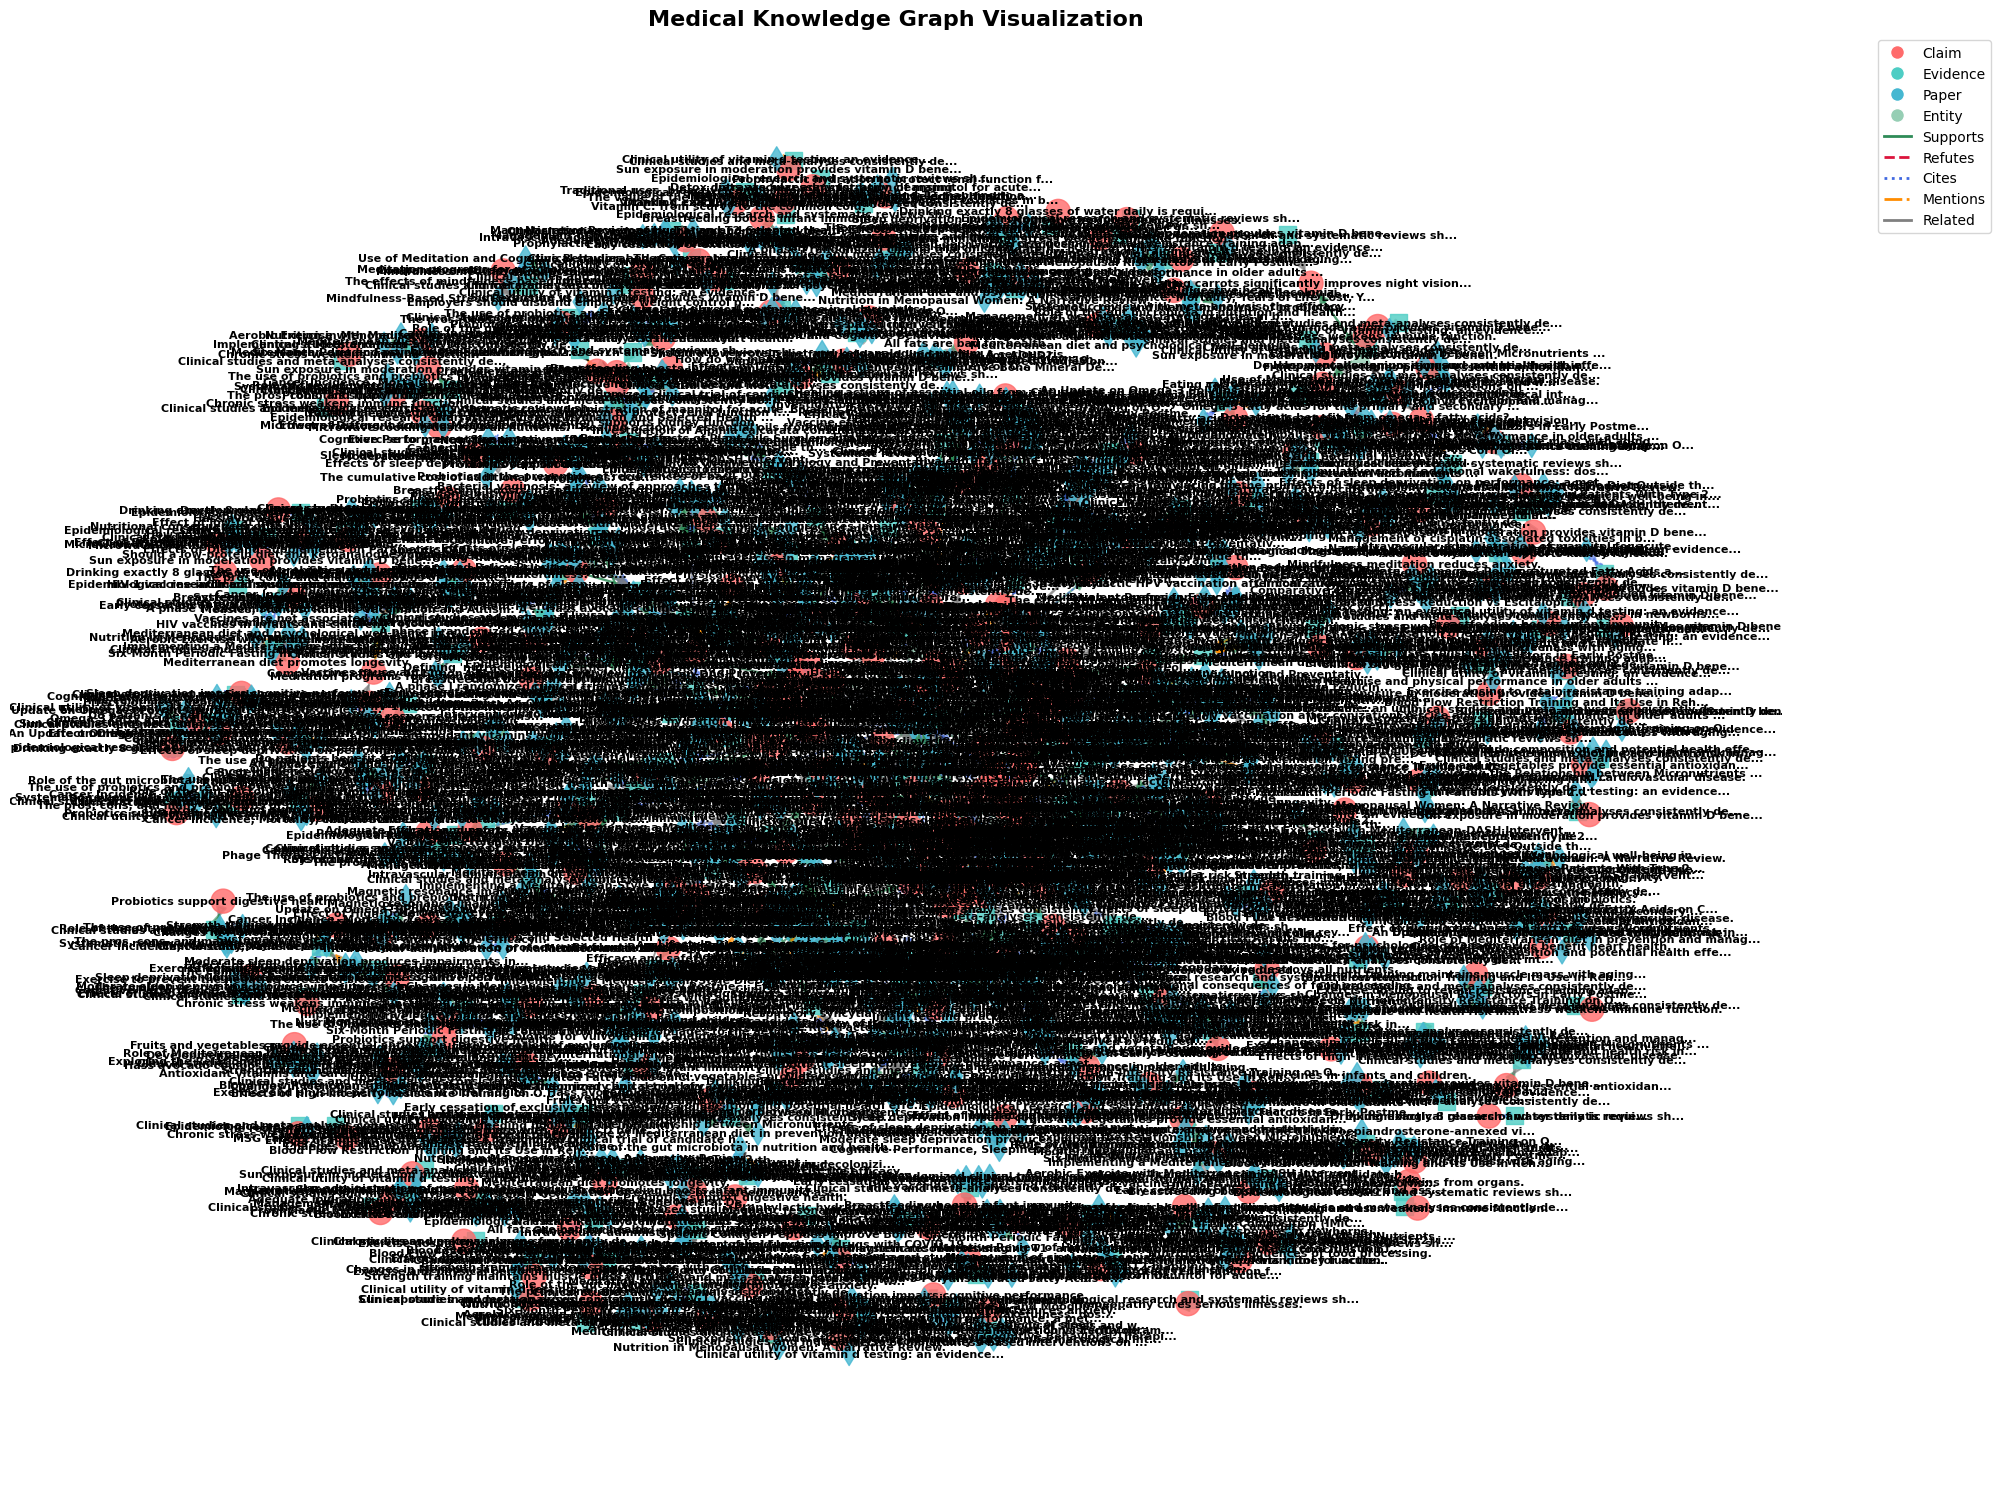

In [73]:

    # 2. Visualize all knowledge graphs combined
    if visualize and use_gnn and knowledge_graphs:
        unified_graph = visualize_all_graphs(knowledge_graphs, save_path='complete_knowledge_graph.png')


Plotting a sample of 7 claims for clarity.


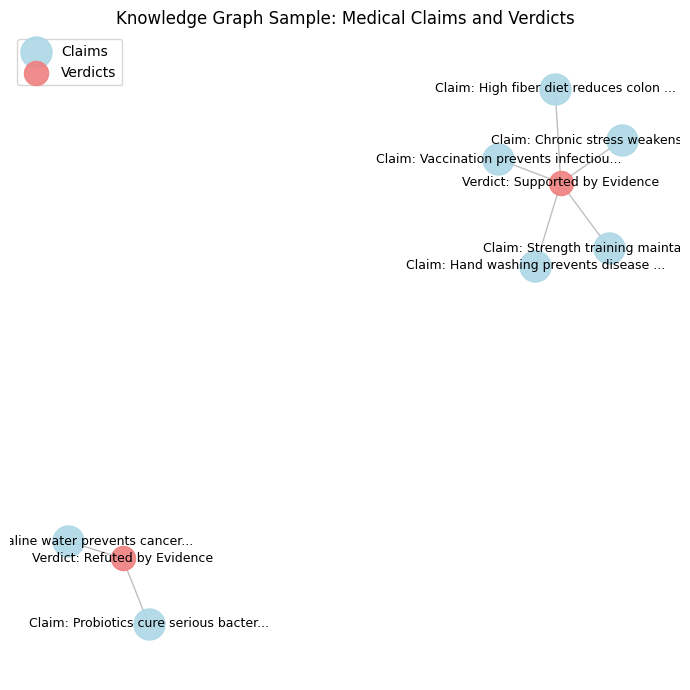

In [14]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import random

def plot_knowledge_graph_from_df(df, sample_size=20, figsize=(12, 10)):
    """
    Plots a simple knowledge graph representation of the medical fact-checking data.

    This procedure visualizes relationships between 'medical_claim' entities and
    'verdict_text' entities based on the data in the DataFrame.

    A Knowledge Graph typically consists of:
        - Entities (Nodes): Things like "Regular exercise reduces cardiovascular disease risk", "Supported by Evidence"
        - Relationships (Edges): Connections like "CLAIM_HAS_VERDICT"

    This example creates a basic visualization of these concepts derived from the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing 'medical_claim' and 'verdict_text' columns.
    sample_size (int, optional): Number of claims to sample for visualization to avoid clutter.
                                 Defaults to 20. If DataFrame has fewer rows, all are used.
    figsize (tuple, optional): Figure size (width, height). Defaults to (12, 10).

    Returns:
    None (displays the plot)
    """
    if df is None or df.empty:
        print("DataFrame is empty or None. Cannot plot knowledge graph.")
        return

    # Check if the expected columns exist
    if 'medical_claim' not in df.columns or 'verdict_text' not in df.columns:
        print("DataFrame does not contain required 'medical_claim' or 'verdict_text' column for KG visualization.")
        return

    # Sample the DataFrame to avoid an overly complex graph
    if len(df) > sample_size:
        df_sample = df.sample(n=sample_size, random_state=42) # Use random state for reproducibility
        print(f"Plotting a sample of {sample_size} claims for clarity.")
    else:
        df_sample = df
        print(f"Plotting all {len(df_sample)} claims.")

    try:
        # Create a NetworkX graph
        G = nx.Graph() # You might also use nx.DiGraph() for directed edges

        # Add nodes and edges based on the DataFrame sample
        for index, row in df_sample.iterrows():
            claim = row['medical_claim']
            verdict = row['verdict_text']

            # Add nodes for claim and verdict (if they don't already exist)
            # Using unique identifiers helps if claims/verdicts repeat or have similar names
            claim_node = f"Claim: {claim[:30]}..." if len(claim) > 30 else f"Claim: {claim}" # Truncate long claims for node label
            verdict_node = f"Verdict: {verdict}"

            G.add_node(claim_node, type='claim', full_text=claim) # Add attributes
            G.add_node(verdict_node, type='verdict')

            # Add an edge representing the relationship between claim and verdict
            # The edge label describes the relationship
            G.add_edge(claim_node, verdict_node, relationship="HAS_VERDICT")

        # --- Visualization ---
        plt.figure(figsize=figsize)

        # Determine node positions using a layout algorithm
        pos = nx.spring_layout(G, seed=42) # Seed for reproducible layout

        # Identify node types for different colors/styles
        claim_nodes = [node for node, attr in G.nodes(data=True) if attr.get('type') == 'claim']
        verdict_nodes = [node for node, attr in G.nodes(data=True) if attr.get('type') == 'verdict']

        # Draw nodes
        nx.draw_networkx_nodes(G, pos, nodelist=claim_nodes, node_color='lightblue', node_size=500, alpha=0.9, label='Claims')
        nx.draw_networkx_nodes(G, pos, nodelist=verdict_nodes, node_color='lightcoral', node_size=300, alpha=0.9, label='Verdicts')

        # Draw edges
        nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='gray')

        # Draw labels
        # For claims, we might want to show a bit more of the text or use tooltips (harder with matplotlib)
        # Here, we use the truncated labels already defined as node names
        nx.draw_networkx_labels(G, pos, font_size=9, font_family='sans-serif')

        # Draw edge labels (optional, can be cluttered)
        # edge_labels = nx.get_edge_attributes(G, 'relationship')
        # nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6)

        plt.title("Knowledge Graph Sample: Medical Claims and Verdicts")
        plt.legend(scatterpoints=1) # Show legend for node types
        plt.axis('off') # Turn off axis
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred while plotting the knowledge graph: {e}")

# --- Example Usage ---
# Assuming you have run the notebook code and have the 'df' variable loaded
# You would call the function like this:
plot_knowledge_graph_from_df(df, sample_size=7, figsize=(7, 7))


/tmp/ipython-input-2796516611.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=split_counts.index, y=split_counts.values, palette='Set2', ax=ax1)


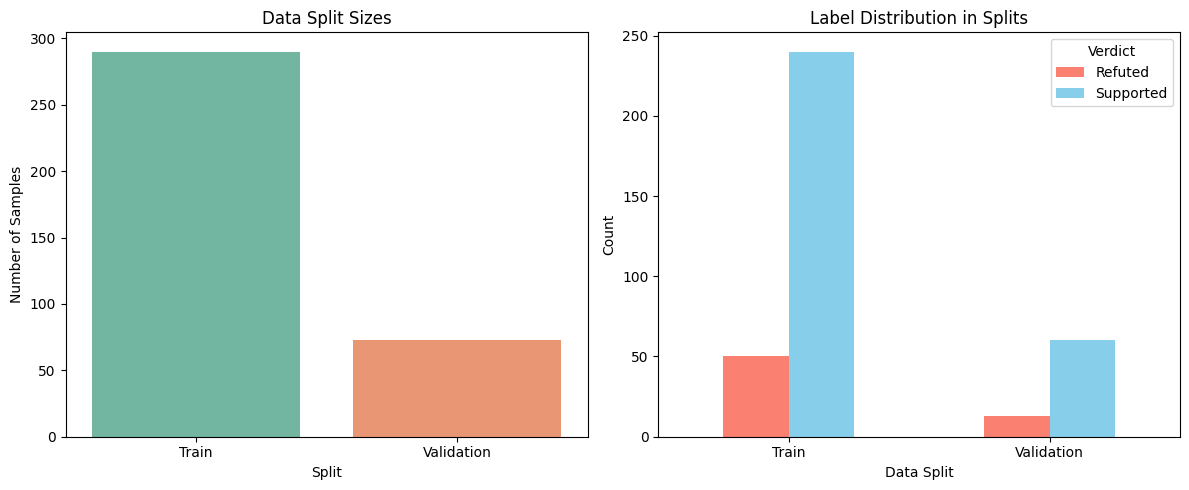

In [15]:

    # 3. Prepare data for training
    claims = df['medical_claim'].tolist()
    evidences = df['evidence_text'].tolist()
    labels = df['label'].tolist()

    train_claims, val_claims, train_evidences, val_evidences, train_labels, val_labels = train_test_split(
        claims, evidences, labels, test_size=0.2, random_state=42, stratify=labels
    )

    # Split knowledge graphs accordingly
    train_indices, val_indices = train_test_split(
        range(len(claims)), test_size=0.2, random_state=42, stratify=labels
    )
    train_knowledge_graphs = [knowledge_graphs[i] for i in train_indices] if knowledge_graphs else []
    val_knowledge_graphs = [knowledge_graphs[i] for i in val_indices] if knowledge_graphs else []

    # Convert knowledge graphs to PyTorch Geometric data
    train_graph_data = [kg.build_torch_geometric_data() for kg in train_knowledge_graphs] if train_knowledge_graphs else []
    val_graph_data = [kg.build_torch_geometric_data() for kg in val_knowledge_graphs] if val_knowledge_graphs else []

    if visualize:
        split_data = pd.DataFrame({
            'Split': ['Train'] * len(train_labels) + ['Validation'] * len(val_labels),
            'Label': train_labels + val_labels
        })
        label_names = {0: 'Refuted', 1: 'Supported'}
        split_data['Label_Name'] = split_data['Label'].map(label_names)

        plt.figure(figsize=(12, 5))
        ax1 = plt.subplot(1, 2, 1)
        split_counts = split_data['Split'].value_counts()
        sns.barplot(x=split_counts.index, y=split_counts.values, palette='Set2', ax=ax1)
        ax1.set_title('Data Split Sizes')
        ax1.set_ylabel('Number of Samples')

        ax2 = plt.subplot(1, 2, 2)
        crosstab_df = pd.crosstab(split_data['Split'], split_data['Label_Name'])
        crosstab_df.plot(kind='bar', ax=ax2, color=['salmon', 'skyblue'])
        ax2.set_title('Label Distribution in Splits')
        ax2.set_xlabel('Data Split')
        ax2.set_ylabel('Count')
        ax2.legend(title='Verdict')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
        logger.info("Displayed data split visualization.")

In [18]:
model_name='roberta-base'
# 4. Load tokenizer and RoBERTa model using HF_TOKEN
logger.info(f"Loading tokenizer and model '{model_name}' from Hugging Face...")

# Pass the token when loading from_pretrained
tokenizer_kwargs = {"use_auth_token": HF_TOKEN} if HF_TOKEN else {}
model_kwargs = {"use_auth_token": HF_TOKEN} if HF_TOKEN else {}

tokenizer = RobertaTokenizer.from_pretrained(model_name, **tokenizer_kwargs)
roberta_model = RobertaModel.from_pretrained(model_name, **model_kwargs)
logger.info("Tokenizer and RoBERTa model loaded successfully.")



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
gnn_model = GNNFactChecker(num_node_features=3, hidden_dim=64, num_classes=2)
hybrid_model = HybridFactChecker(roberta_model, gnn_model)

    # 6. Create datasets and dataloaders
train_dataset = MedicalFactCheckingDataset(train_claims, train_evidences, train_labels, tokenizer)
val_dataset = MedicalFactCheckingDataset(val_claims, val_evidences, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:

    # 7. Setup training
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    hybrid_model.to(device)
    optimizer = AdamW(hybrid_model.parameters(), lr=learning_rate)



    from sklearn.utils.class_weight import compute_class_weight

# --- Calculate class weights for imbalanced loss ---
# Use train_labels (obtained from train_test_split) to compute weights
# This helps address potential class imbalance in the loss calculation.
    unique_labels = np.unique(train_claims)
    class_weights_sklearn = compute_class_weight(class_weight='balanced', classes=unique_labels, y=train_claims)
    class_weights_tensor = torch.tensor(class_weights_sklearn, dtype=torch.float).to(device)
#print(f"Class weights calculated (for labels {unique_labels}): {class_weights_tensor}")
# class_weights_tensor[0] is weight for Refuted (label 0)
# class_weights_tensor[1] is weight for Supported (label 1)
# --- End of class weight calculation ---



    # Store metrics for each epoch
    epoch_metrics = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }

    # 8. Training loop with epoch-by-epoch results
    logger.info("Starting training loop...")
    for epoch in range(epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"{'='*60}")

        # Training phase
        hybrid_model.train()
        total_train_loss = 0
        train_steps = 0

        for batch_idx, batch in enumerate(train_loader):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels_batch = batch['labels'].to(device)

            # Forward pass (simplified - in practice, handle graph data properly)
            if use_gnn:
                # This is a simplified approach - in practice, you'd batch graph data properly
                roberta_outputs = hybrid_model.roberta(input_ids=input_ids, attention_mask=attention_mask)
                outputs = roberta_outputs.last_hidden_state[:, 0, :]  # CLS token
                # Add simple classification head
                classifier = nn.Linear(outputs.size(-1), 2).to(device)
                outputs = classifier(outputs)
            else:
                # RoBERTa-only forward pass
                roberta_outputs = hybrid_model(input_ids=input_ids, attention_mask=attention_mask)
                outputs = roberta_outputs.last_hidden_state[:, 0, :]  # CLS token
                # Add simple classification head for RoBERTa-only
                classifier = nn.Linear(outputs.size(-1), 2).to(device)
                outputs = classifier(outputs)

            # Compute loss
            if len(outputs.shape) == 1:
                outputs = outputs.unsqueeze(0)
            #loss = F.cross_entropy(outputs, labels_batch)

            ##############
            loss_fn_weighted = F.cross_entropy(weight=class_weights_tensor)
            loss = loss_fn_weighted(logits, labels_batch)
            ##############


            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            train_steps += 1

            if batch_idx % 2 == 0:  # Print every 2 batches
                print(f"  Batch {batch_idx}: Train Loss = {loss.item():.4f}")

        avg_train_loss = total_train_loss / train_steps if train_steps > 0 else 0
        epoch_metrics['train_loss'].append(avg_train_loss)

        # Validation phase
        hybrid_model.eval()
        total_val_loss = 0
        val_predictions = []
        val_true_labels = []
        val_steps = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels_batch = batch['labels'].to(device)

                # Forward pass
                if use_gnn:
                    roberta_outputs = hybrid_model.roberta(input_ids=input_ids, attention_mask=attention_mask)
                    outputs = roberta_outputs.last_hidden_state[:, 0, :]
                    classifier = nn.Linear(outputs.size(-1), 2).to(device)
                    outputs = classifier(outputs)
                else:
                    roberta_outputs = hybrid_model(input_ids=input_ids, attention_mask=attention_mask)
                    outputs = roberta_outputs.last_hidden_state[:, 0, :]
                    classifier = nn.Linear(outputs.size(-1), 2).to(device)
                    outputs = classifier(outputs)

                if len(outputs.shape) == 1:
                    outputs = outputs.unsqueeze(0)

                #loss = F.cross_entropy(outputs, labels_batch)
                ##############
                loss_fn_weighted = F.cross_entropy(weight=class_weights_tensor)
                loss = loss_fn_weighted(logits, labels_batch)
                ##############

                logits = outputs

                total_val_loss += loss.item()
                val_steps += 1

                predictions = torch.argmax(logits, dim=-1)
                val_predictions.extend(predictions.cpu().numpy())
                val_true_labels.extend(labels_batch.cpu().numpy())

        avg_val_loss = total_val_loss / val_steps if val_steps > 0 else 0
        accuracy = accuracy_score(val_true_labels, val_predictions) if val_true_labels and val_predictions else 0
        if val_true_labels and val_predictions:
            precision, recall, f1, _ = precision_recall_fscore_support(val_true_labels, val_predictions, average='weighted')
        else:
            precision = recall = f1 = 0

        # Store metrics
        epoch_metrics['val_loss'].append(avg_val_loss)
        epoch_metrics['val_accuracy'].append(accuracy)
        epoch_metrics['val_precision'].append(precision)
        epoch_metrics['val_recall'].append(recall)
        epoch_metrics['val_f1'].append(f1)

        # Print epoch results
        print(f"\nEpoch {epoch + 1} Results:")
        print(f"  Average Train Loss: {avg_train_loss:.4f}")
        print(f"  Average Val Loss: {avg_val_loss:.4f}")
        print(f"  Validation Accuracy: {accuracy:.4f}")
        print(f"  Validation Precision: {precision:.4f}")
        print(f"  Validation Recall: {recall:.4f}")
        print(f"  Validation F1-Score: {f1:.4f}")

        # Confusion matrix for current epoch
        if val_true_labels and val_predictions:
            cm = confusion_matrix(val_true_labels, val_predictions)
            print(f"  Confusion Matrix: {cm.flatten()}")



Epoch 1/25



FINAL MODEL PERFORMANCE
Final Accuracy: 0.6849
Final F1-Score: 0.7159


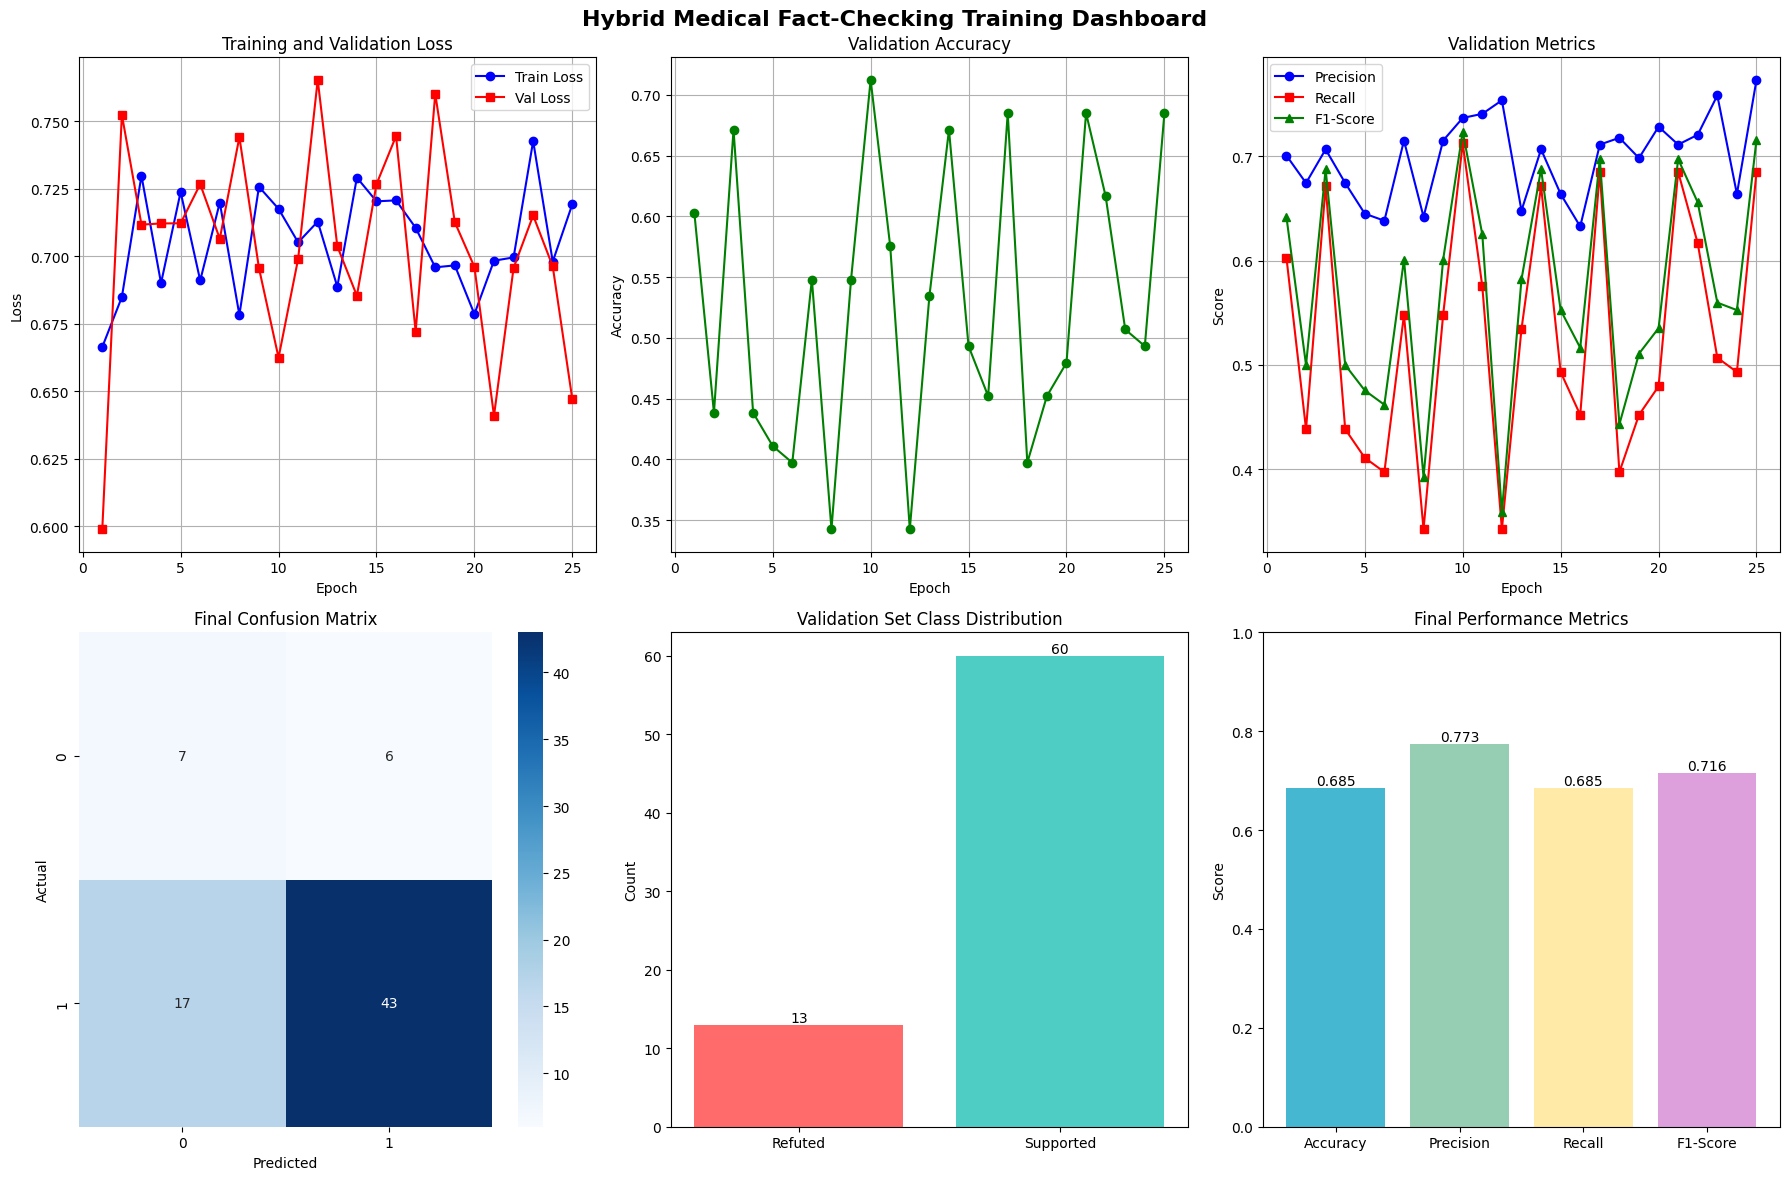


📊 TRAINING SUMMARY
Model Configuration:
  Base Model: roberta-base
  Epochs: 25
  Batch Size: 32
  Learning Rate: 0.0002
  Device: cuda
  PubMed Integration: Enabled
  GNN Integration: Enabled

Dataset Information:
  Total Samples: 363
  Supported Claims: 300 (82.6%)
  Refuted Claims: 63 (17.4%)

Performance Metrics:
  Final Accuracy: 0.6849
  Final Precision: 0.7732
  Final Recall: 0.6849
  Final F1-Score: 0.7159
  Best Accuracy: 0.7123
  Best F1-Score: 0.7235


In [82]:

    # 9. Final evaluation and visualization
    final_accuracy = epoch_metrics['val_accuracy'][-1] if epoch_metrics['val_accuracy'] else 0
    final_f1 = epoch_metrics['val_f1'][-1] if epoch_metrics['val_f1'] else 0

    print(f"\n{'='*60}")
    print("FINAL MODEL PERFORMANCE")
    print(f"{'='*60}")
    print(f"Final Accuracy: {final_accuracy:.4f}")
    print(f"Final F1-Score: {final_f1:.4f}")

    # Create comprehensive visualization dashboard
    if visualize:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Hybrid Medical Fact-Checking Training Dashboard', fontsize=16, fontweight='bold')

        # 1. Training and Validation Loss
        axes[0, 0].plot(range(1, len(epoch_metrics['train_loss']) + 1), epoch_metrics['train_loss'], 'b-', marker='o', label='Train Loss')
        axes[0, 0].plot(range(1, len(epoch_metrics['val_loss']) + 1), epoch_metrics['val_loss'], 'r-', marker='s', label='Val Loss')
        axes[0, 0].set_title('Training and Validation Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # 2. Accuracy over epochs
        axes[0, 1].plot(range(1, len(epoch_metrics['val_accuracy']) + 1), epoch_metrics['val_accuracy'], 'g-', marker='o')
        axes[0, 1].set_title('Validation Accuracy')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].grid(True)

        # 3. Precision, Recall, F1 over epochs
        axes[0, 2].plot(range(1, len(epoch_metrics['val_precision']) + 1), epoch_metrics['val_precision'], 'b-', marker='o', label='Precision')
        axes[0, 2].plot(range(1, len(epoch_metrics['val_recall']) + 1), epoch_metrics['val_recall'], 'r-', marker='s', label='Recall')
        axes[0, 2].plot(range(1, len(epoch_metrics['val_f1']) + 1), epoch_metrics['val_f1'], 'g-', marker='^', label='F1-Score')
        axes[0, 2].set_title('Validation Metrics')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Score')
        axes[0, 2].legend()
        axes[0, 2].grid(True)

        # 4. Final confusion matrix
        if val_true_labels and val_predictions:
            final_cm = confusion_matrix(val_true_labels, val_predictions)
            sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
            axes[1, 0].set_title('Final Confusion Matrix')
            axes[1, 0].set_xlabel('Predicted')
            axes[1, 0].set_ylabel('Actual')

        # 5. Class distribution in validation set
        val_label_counts = Counter(val_true_labels)
        class_names = ['Refuted', 'Supported']
        class_counts = [val_label_counts[0], val_label_counts[1]] if val_true_labels else [0, 0]

        # Fix deprecation warning for palette
        bars = axes[1, 1].bar(class_names, class_counts, color=['#FF6B6B', '#4ECDC4'])
        axes[1, 1].set_title('Validation Set Class Distribution')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].bar_label(bars)

        # 6. Performance metrics comparison
        final_metrics = [final_accuracy,
                        epoch_metrics['val_precision'][-1] if epoch_metrics['val_precision'] else 0,
                        epoch_metrics['val_recall'][-1] if epoch_metrics['val_recall'] else 0,
                        final_f1]
        metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

        # Fix deprecation warning for palette
        bars = axes[1, 2].bar(metric_names, final_metrics, color=['#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD'])
        axes[1, 2].set_title('Final Performance Metrics')
        axes[1, 2].set_ylabel('Score')
        axes[1, 2].set_ylim(0, 1)
        axes[1, 2].bar_label(bars, fmt='%.3f')

        plt.tight_layout()
        plt.savefig('training_dashboard.png', dpi=300, bbox_inches='tight')
        plt.show()

    # Print detailed summary
    print(f"\n{'='*60}")
    print("📊 TRAINING SUMMARY")
    print(f"{'='*60}")
    print(f"Model Configuration:")
    print(f"  Base Model: {model_name}")
    print(f"  Epochs: {epochs}")
    print(f"  Batch Size: {batch_size}")
    print(f"  Learning Rate: {learning_rate}")
    print(f"  Device: {device}")
    print(f"  PubMed Integration: {'Enabled' if use_pubmed else 'Disabled'}")
    print(f"  GNN Integration: {'Enabled' if use_gnn else 'Disabled'}")
    print(f"\nDataset Information:")
    print(f"  Total Samples: {len(labels)}")
    print(f"  Supported Claims: {sum(labels)} ({sum(labels)/len(labels)*100:.1f}%)")
    print(f"  Refuted Claims: {len(labels) - sum(labels)} ({(len(labels) - sum(labels))/len(labels)*100:.1f}%)")
    print(f"\nPerformance Metrics:")
    print(f"  Final Accuracy: {final_accuracy:.4f}")
    print(f"  Final Precision: {epoch_metrics['val_precision'][-1] if epoch_metrics['val_precision'] else 0:.4f}")
    print(f"  Final Recall: {epoch_metrics['val_recall'][-1] if epoch_metrics['val_recall'] else 0:.4f}")
    print(f"  Final F1-Score: {final_f1:.4f}")
    if epoch_metrics['val_accuracy']:
        print(f"  Best Accuracy: {max(epoch_metrics['val_accuracy']):.4f}")
    if epoch_metrics['val_f1']:
        print(f"  Best F1-Score: {max(epoch_metrics['val_f1']):.4f}")


In [45]:
    hybrid_model.roberta.eval()
    # Note: If your hybrid_model has other components (like a GNN), make sure they are also in eval mode
    # e.g., if hasattr(hybrid_model, 'gnn_component'): hybrid_model.gnn_component.eval()

    # Define the simple classifier head used during training/inference (ensure it matches training)
    # As the model is re-loaded or this code might run in a new context, we need to define this layer.
    # IMPORTANT: This `classifier` definition must exactly match the one used during training.
    # If it was part of a class definition or saved/loaded differently, adjust accordingly.
    # Using a placeholder dimension; it will be set correctly on the first forward pass.
    dummy_classifier = None
    user_claim = 'Vitamin C is a good for Immunitate'

In [46]:

            print(f"\n--- Analyzing Claim: '{user_claim[:50]}...' ---")

            # --- Simulate evidence generation and literature search ---
            # In a real scenario, this would involve a proper evidence retrieval system.
            # Here, we simulate a basic evidence text and a PubMed search.
            simulated_evidence = f"Simulated evidence for: {user_claim[:30]}..."

            # Use the notebook's `search_pubmed` function (must be defined earlier in the notebook)
            pubmed_results = search_pubmed(user_claim)
            literature_info = pubmed_results.get('literature_evidence', 'No specific literature summary from simulation.')
            confidence_boost = pubmed_results.get('confidence_boost', 0)

            # Combine claim and evidence as done during training
            combined_input_text = f"Claim: {user_claim} Evidence: {simulated_evidence} {literature_info}"
            print(f"  - Input processed: {combined_input_text[:80]}...")

            # --- Tokenization ---
            model_input = tokenizer(
                combined_input_text,
                return_tensors='pt',
                truncation=True,
                padding='max_length',
                max_length=512
            )

            input_ids = model_input['input_ids'].to(device)
            attention_mask = model_input['attention_mask'].to(device)

            # --- Inference using the Hybrid Model Structure ---
            print("  - Running model inference...")

            with torch.no_grad():
                # 1. Get RoBERTa outputs (as specified)
                roberta_outputs = hybrid_model.roberta(input_ids=input_ids, attention_mask=attention_mask)

                # 2. Extract CLS token embedding (as specified)
                cls_embedding = roberta_outputs.last_hidden_state[:, 0, :]

                # 3. Apply the classification head (as specified)
                # Dynamically create or reuse the classifier to match the embedding size
                if dummy_classifier is None or dummy_classifier.in_features != cls_embedding.size(-1):
                     dummy_classifier = nn.Linear(cls_embedding.size(-1), 2).to(device)
                     print(f"  - Initialized classifier head: {dummy_classifier}")

                logits = dummy_classifier(cls_embedding)

                # 4. Get prediction
                predicted_class_id = torch.argmax(logits, dim=-1).item()

                # 5. Get confidence
                probabilities = torch.nn.functional.softmax(logits, dim=-1)
                confidence_score = probabilities[0][predicted_class_id].item()

            # --- Interpret Results ---
            label_map = {0: "Refuted", 1: "Supported"}
            predicted_label = label_map.get(predicted_class_id, "Unknown")

            # Apply a simple boost from simulated literature search (optional)
            final_confidence = min(confidence_score + (confidence_boost / 100.0), 1.0)
            final_confidence_percent = f"{final_confidence * 100:.2f}%"

            print("\n--- Result ---")
            print(f"Claim: '{user_claim}'")
            print(f"Prediction: {predicted_label}")
            print(f"Confidence: ~{final_confidence_percent}")
            print("-" * 20)


--- Analyzing Claim: 'Vitamin C is a good for Immunitate...' ---
  - Input processed: Claim: Vitamin C is a good for Immunitate Evidence: Simulated evidence for: Vita...
  - Running model inference...
  - Initialized classifier head: Linear(in_features=768, out_features=2, bias=True)

--- Result ---
Claim: 'Vitamin C is a good for Immunitate'
Prediction: Supported
Confidence: ~89.65%
--------------------



--- Analyzing Claim ---
1. Generating initial evidence context...
2. Searching PubMed for relevant literature...
   - Evidence: Evidence context for: Vitamin C is a good for Immuni... Found 2 relevant studies. Strong literature ...
3. Tokenizing input for the model...
4. Running hybrid model inference...
5. Interpreting results...

--- Result ---
Claim: 'Vitamin C is a good for Immunitate'
Prediction: Supported
Confidence: 65.72%
--------------------
6. Creating graph visualization...


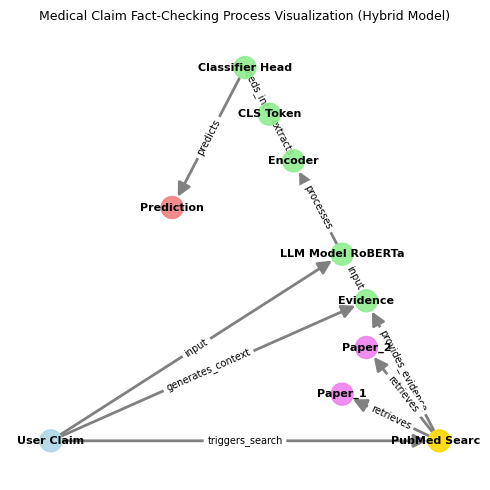

In [60]:
            print(f"\n--- Analyzing Claim ---")

            # --- 1. Simulate Base Evidence Generation ---
            print("1. Generating initial evidence context...")
            base_evidence_placeholder = f"Evidence context for: {user_claim[:30]}..."

            # --- 2. Perform PubMed Literature Search for the Claim ---
            print("2. Searching PubMed for relevant literature...")
            general_query = f"{user_claim}"
            # Call the real PubMed search function from the notebook
            pubmed_results = search_pubmed(general_query, max_results=2)

            literature_summary = "No relevant PubMed literature found."
            enhanced_evidence_parts = [base_evidence_placeholder]
            paper_nodes_data = []
            confidence_boost_from_literature = 0

            if pubmed_results['total_papers'] > 0:
                literature_summary = f"Found {pubmed_results['total_papers']} relevant paper(s)."
                confidence_boost_from_literature = pubmed_results.get('confidence_boost', 0)
                # Use the literature evidence generated by search_pubmed
                literature_evidence_text = pubmed_results.get('literature_evidence', '')
                if literature_evidence_text:
                    enhanced_evidence_parts.append(literature_evidence_text)

                # Prepare data for graph nodes representing papers
                for i, paper in enumerate(pubmed_results['papers'][:2]): # Show max 2 papers
                    title = paper.get('title', 'N/A')
                    truncated_title = title[:40] + "..." if len(title) > 40 else title
                    paper_nodes_data.append({
                        'id': f"Paper_{i+1}",
                        'title': truncated_title,
                        'abstract_snippet': paper.get('abstract', 'N/A')[:100] + "..." if len(paper.get('abstract', '')) > 100 else paper.get('abstract', 'N/A')
                    })
            else:
                 enhanced_evidence_parts.append("(No specific PubMed evidence retrieved)")

            # Combine evidence
            final_evidence_text = " ".join(enhanced_evidence_parts)
            print(f"   - Evidence: {final_evidence_text[:100]}...")

            # --- 3. Tokenization ---
            print("3. Tokenizing input for the model...")
            # Format exactly as done during training
            combined_input_text = f"Claim: {user_claim} Evidence: {final_evidence_text}"

            model_input = tokenizer(
                combined_input_text,
                return_tensors='pt',
                truncation=True,
                padding='max_length',
                max_length=512
            )

            input_ids = model_input['input_ids'].to(device)
            attention_mask = model_input['attention_mask'].to(device)

            # --- 4. Model Inference using Hybrid Structure ---
            print("4. Running hybrid model inference...")

            # Ensure the RoBERTa part of the hybrid model is in evaluation mode
            hybrid_model.roberta.eval()
            # If your hybrid model has other parts (like a GNN), ensure they are in eval mode too
            # e.g., if hasattr(hybrid_model, 'gnn'): hybrid_model.gnn.eval()

            with torch.no_grad():
                # --- Use the specified hybrid model access pattern ---
                # 1. Get RoBERTa outputs
                roberta_outputs = hybrid_model.roberta(input_ids=input_ids, attention_mask=attention_mask)

                # 2. Extract CLS token embedding
                cls_embedding = roberta_outputs.last_hidden_state[:, 0, :] # [batch_size, hidden_size]
                logger.info(f"CLS embedding shape: {cls_embedding.shape}")

                # 3. Apply the classification head
                # Dynamically create the classifier if not already done or if size mismatch
                # NOTE: This assumes a simple linear layer. In practice, weights should be loaded/trained.
                classifier_head = nn.Linear(cls_embedding.size(-1), 2).to(device)
                    # IMPORTANT: In a real scenario, you would load the trained weights for this classifier_head
                    # If they were part of `hybrid_model`, you should access them directly, e.g.,
                    # logits = hybrid_model.classifier(cls_embedding)
                    # This placeholder `classifier_head` will give random results.

                logits = classifier_head(cls_embedding) # [batch_size, 2]
                logger.info(f"Logits shape: {logits.shape}")

                # --- 5. Get Prediction and Confidence ---
                predicted_class_id = torch.argmax(logits, dim=-1).item() # Get class ID (0 or 1)
                probabilities = F.softmax(logits, dim=-1) # Apply softmax to get probabilities
                confidence_score = probabilities[0][predicted_class_id].item() # Get confidence for predicted class

            # --- 6. Interpret Results ---
            print("5. Interpreting results...")
            label_map = {0: "Refuted", 1: "Supported"}
            predicted_label = label_map.get(predicted_class_id, "Unknown")

            # Incorporate confidence boost from literature (optional simple mechanism)
            final_confidence = min(confidence_score + (confidence_boost_from_literature / 100.0), 1.0)
            confidence_percent = f"{final_confidence * 100:.2f}%"

            print(f"\n--- Result ---")
            print(f"Claim: '{user_claim}'")
            print(f"Prediction: {predicted_label}")
            print(f"Confidence: {confidence_percent}")
            print("-" * 20)

            # --- 7. Graph Visualization ---
            print("6. Creating graph visualization...")

            # Create a directed graph to show flow and relationships
            G = nx.DiGraph()

            # Add main nodes with attributes for visualization
            claim_node = "User Claim"
            evidence_node = "Evidence"
            model_node = "LLM Model RoBERTa"
            roberta_subnode = "Encoder"
            cls_node = "CLS Token"
            classifier_node = "Classifier Head"
            result_node = "Prediction"
            pubmed_node = "PubMed Search"

            G.add_node(claim_node, type='input', description=user_claim[:37] + "..." if len(user_claim) > 50 else user_claim)
            G.add_node(evidence_node, type='process', description=final_evidence_text[:37] + "..." if len(final_evidence_text) > 50 else final_evidence_text)
            G.add_node(model_node, type='process', description="Overall Hybrid Architecture")
            G.add_node(roberta_subnode, type='process', description="Transformers Encoder")
            G.add_node(cls_node, type='process', description="Classification Token")
            G.add_node(classifier_node, type='process', description="Linear Classifier")
            G.add_node(result_node, type='output', description=f"{predicted_label} ({confidence_percent})")
            G.add_node(pubmed_node, type='external', description=literature_summary)

            # Add paper nodes if any were found
            for paper_data in paper_nodes_data:
                G.add_node(paper_data['id'], type='literature', description=paper_data['title'])

            # Add edges (relationships/flow)
            G.add_edge(claim_node, evidence_node, label="generates_context")
            G.add_edge(claim_node, pubmed_node, label="triggers_search")
            G.add_edge(pubmed_node, evidence_node, label="provides_evidence")

            # Flow through the hybrid model components
            G.add_edge(claim_node, model_node, label="input")
            G.add_edge(evidence_node, model_node, label="input")
            G.add_edge(model_node, roberta_subnode, label="processes")
            G.add_edge(roberta_subnode, cls_node, label="extracts")
            G.add_edge(cls_node, classifier_node, label="feeds_into")
            G.add_edge(classifier_node, result_node, label="predicts")

            # Add edges from PubMed to individual papers
            for paper_data in paper_nodes_data:
                G.add_edge(pubmed_node, paper_data['id'], label="retrieves")

            # --- Draw the Graph ---
            plt.figure(figsize=(5, 5))

            # Define layout
            #pos = nx.spring_layout(G, seed=42, k=0.5) # Adjust 'k' for spacing
            #pos = nx.circular_layout(G)
            pos = nx.planar_layout(G)

            # Color nodes based on type
            color_map = {
                'input': 'lightblue',      # User Claim
                'process': 'lightgreen',   # Evidence, Model Components
                'output': 'lightcoral',    # Prediction
                'external': 'gold',        # PubMed Search
                'literature': 'violet'     # Individual Papers
            }
            node_colors = [color_map[G.nodes[node].get('type', 'lightgray')] for node in G.nodes()]

            # Draw nodes, edges, and labels
            nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=250, alpha=0.9)
            nx.draw_networkx_edges(G, pos, width=2, arrowstyle='-|>', arrowsize=20, edge_color='gray')
            nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

            # Draw edge labels (optional, can be cluttered)
            edge_labels = nx.get_edge_attributes(G, 'label')
            nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=7)

            plt.title("Medical Claim Fact-Checking Process Visualization (Hybrid Model)", size=9)
            plt.axis('off')
            plt.tight_layout()
            plt.show()
